In this notebook we use Quantum State Tomography (QST) to obtain fidelities of Rx(θ) interactions, using:

1. a standard decomposition using 2 X90 pulses
2. an optimized implementation using a scaled X180 pulse

The state on which we do tomography is produced by the following circuit and produces a sinusoid probability of reading out 1.
```
        ┌────────┐
q_0: |0>┤  Rx(θ) ├
        └────────┘
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

from qiskit import IBMQ, pulse, schedule, transpile, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.pulse import pulse_lib as pulse_library, reschedule
from qiskit.ignis.measurement.discriminator.iq_discriminators import LinearIQDiscriminator
from qiskit.ignis.measurement.discriminator.filters import DiscriminationFilter
import qiskit.ignis.mitigation.measurement as mit
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography.basis import PauliBasis
from qiskit.visualization.state_visualization import plot_state_city
from qiskit.quantum_info import state_fidelity
from qiskit.circuit import Gate
from qiskit.scheduler import schedule_circuit, ScheduleConfig
from qiskit.quantum_info import state_fidelity, process_fidelity

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [4]:
import pulse_compiler_helper_fns

In [5]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])
config = backend.configuration()
props = backend.properties()

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


### experiment parameters

In [7]:
def qubit_t1(qubit):
    return props.qubits[qubit][0].value

def qubit_t2(qubit):
    return props.qubits[qubit][1].value

def sort_qubits_by_t1():
    """in ascending order"""
    qubits = [i for i in range(config.n_qubits)]
    qubits = sorted(qubits, key=qubit_t1)
    return qubits

In [8]:
sort_qubits_by_t1()

[7, 4, 11, 16, 1, 14, 6, 17, 12, 15, 10, 18, 8, 2, 13, 3, 19, 5, 9, 0]

In [9]:
shots = 2000
thetas = np.linspace(0, np.pi, 41, endpoint=True)
print(thetas)

[0.         0.07853982 0.15707963 0.23561945 0.31415927 0.39269908
 0.4712389  0.54977871 0.62831853 0.70685835 0.78539816 0.86393798
 0.9424778  1.02101761 1.09955743 1.17809725 1.25663706 1.33517688
 1.41371669 1.49225651 1.57079633 1.64933614 1.72787596 1.80641578
 1.88495559 1.96349541 2.04203522 2.12057504 2.19911486 2.27765467
 2.35619449 2.43473431 2.51327412 2.59181394 2.67035376 2.74889357
 2.82743339 2.9059732  2.98451302 3.06305284 3.14159265]


## Direct RX(θ) Gate

In [10]:
rx_schedules_std = []
rx_schedules_opt = []

## Standard Way: Cnot RZ Cnot
for theta in thetas:
    circuit = q.QuantumCircuit(1)
    circuit.u3(theta, -np.pi/2, np.pi/2, 0)

    transpiled_circuit = q.transpile(circuit, backend, optimization_level=0)

    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
    rx_schedules_std.append(schedule)
    
## Optimized Way: use a direct rotation about X axis
for theta in thetas:
    circuit = q.QuantumCircuit(1)
    circuit.rx(theta, 0)

    decomposed_circuit = circuit.decompose()

    pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
    transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=0)

    schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)    
    rx_schedules_opt.append(schedule)

### Set up State Tomography

In [11]:
def qst_circuits_and_schedules(schedule, theta):
    """
    create the state tomography circuits
    the state preparation circuit is (H $otimes$ H).ZZ.(H $otimes$ H)
    """
    num_qubits = 1
    qubit = [0]
    qr = QuantumRegister(num_qubits)
    my_gate = Gate(name='rx_{}'.format(theta), num_qubits=num_qubits, params=[])

    # create the tomography circuits
    qc = QuantumCircuit(qr)
    qc.append(my_gate, qr[:])
    qst_circuits = state_tomography_circuits(qc, measured_qubits=qr)

    # transpile so that the singles are in terms of the u gates
    qst_circuits = transpile(qst_circuits, backend, initial_layout=qubit,
                             basis_gates=['u1','u2','u3',my_gate.name])

    # add the custom gate to the cmd def
    cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
    cmd_def.add(my_gate.name, qubits=qubit, schedule=schedule)

    # schedule!
    schedule_config = ScheduleConfig(cmd_def, meas_map=backend.configuration().meas_map)
    qst_schedules = [schedule_circuit(circ, schedule_config) for circ in qst_circuits]
    
    return qst_circuits, qst_schedules

In [12]:
tomo_circuits_std = []
tomo_schedules_std = []
for rx_schedule, theta in zip(rx_schedules_std, thetas):
    tomo_circs, tomo_scheds = qst_circuits_and_schedules(rx_schedule, theta)
    tomo_circuits_std.append(tomo_circs)
    tomo_schedules_std.append(tomo_scheds)
    
tomo_circuits_opt = []
tomo_schedules_opt = []
for rx_schedule, theta in zip(rx_schedules_opt, thetas):
    tomo_circs, tomo_scheds = qst_circuits_and_schedules(rx_schedule, theta)
    tomo_circuits_opt.append(tomo_circs)
    tomo_schedules_opt.append(tomo_scheds)

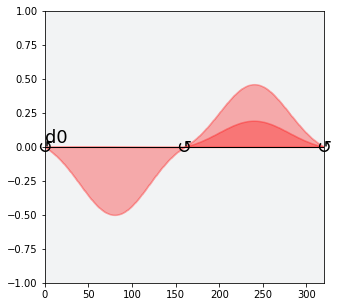

In [15]:
from qiskit.visualization.pulse.matplotlib import SchedStyle
style = SchedStyle(d_ch_color=['r','r'], use_table=False, figsize=(5, 5), remove_spacing=True, dpi=800)
tomo_schedules_std[15][2].filter(channels=[config.drive(0)]).draw(style=style, plot_range=(0,320))

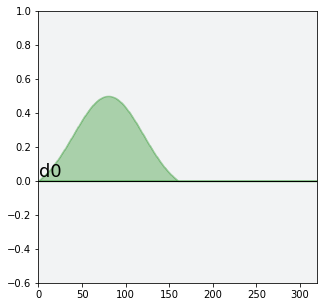

In [16]:
style = SchedStyle(d_ch_color=['g','g'], use_table=False, figsize=(5, 5), remove_spacing=True, dpi=800)
tomo_schedules_opt[15][2].filter(channels=[config.drive(0)]).draw(style=style, plot_range=(0,320))

In [27]:
max(tomo_schedules_std[15][2].instructions[2][1].command.samples)

(0.05406969040632248+0.00016995299665722996j)

In [26]:
max(tomo_schedules_opt[15][2].instructions[0][1].command.samples)

(0.04103397578001022+6.276319197695557e-07j)

### Run tomo experiments

In [14]:
job_std = backend.retrieve_job('5dda00f68aa7e00018b8fc38')
job_opt = backend.retrieve_job('5dda010dfa67c10018cebd1e')
job_mit = backend.retrieve_job('5dda039497300300184d49ce')

In [15]:
import itertools
flat_schedules_std = list(itertools.chain(*tomo_schedules_std))
flat_schedules_opt = list(itertools.chain(*tomo_schedules_opt))

In [ ]:
job_std = q.execute(flat_schedules_std, backend=backend, shots=shots)
job_opt = q.execute(flat_schedules_opt, backend=backend, shots=shots)
print('job_std is %s' % job_std.job_id())
print('job_opt is %s' % job_opt.job_id())

In [16]:
job_std.status()

<JobStatus.DONE: 'job has successfully run'>

In [17]:
job_opt.status()

<JobStatus.DONE: 'job has successfully run'>

### Run a mitigation cal job

In [18]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0])
meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, cmd_def=cmd_def)

In [ ]:
job_mit = q.execute(meas_schedules, backend)

In [19]:
job_mit.status()

<JobStatus.DONE: 'job has successfully run'>

-----
### Fit tomography data to get statevector

In [20]:
from qiskit.result import marginal_counts

In [21]:
result_std = job_std.result()
result_opt = job_opt.result()

In [22]:
# mitigate results
result_mit = marginal_counts(job_mit.result(), [0])
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)
readout_fitter.cal_matrix

array([[0.97167969, 0.08496094],
       [0.02832031, 0.91503906]])

In [23]:
result_std_marg = marginal_counts(result_std, [0])
result_opt_marg = marginal_counts(result_opt, [0])

In [24]:
from copy import deepcopy
result_cpy_std = deepcopy(result_std_marg)
result_cpy_opt = deepcopy(result_opt_marg)

In [25]:
standard_statevectors = []
optimized_statevectors = []

for i, theta in enumerate(thetas):
    result_std_mit = readout_fitter.filter.apply(result_cpy_std)
    result_opt_mit = readout_fitter.filter.apply(result_cpy_opt)
    
    # remove results for other thetas
    # TODO: allow selecting subset of result
    single_qst_size = len(tomo_schedules_std[0])
    del result_std_mit.results[:i*single_qst_size]
    del result_std_mit.results[single_qst_size:]
    del result_opt_mit.results[:i*single_qst_size]
    del result_opt_mit.results[single_qst_size:]
    assert len(result_std_mit.results) == single_qst_size
    assert len(result_opt_mit.results) == single_qst_size

    qst_fitter = StateTomographyFitter(result_std_mit, tomo_circuits_std[i])
    sv = qst_fitter.fit(method='cvx')
    standard_statevectors.append(sv)
    
    qst_fitter = StateTomographyFitter(result_opt_mit, tomo_circuits_opt[i])
    sv = qst_fitter.fit(method='cvx')
    optimized_statevectors.append(sv)

## Analysis

### plot state fidelities

In [26]:
# what are the ideal statevectors
from qiskit.quantum_info.states import Statevector
ideal_statevectors = []
for theta in thetas:
    circuit = QuantumCircuit(1)
    circuit.rx(theta, 0)
    ideal = Statevector.from_instruction(circuit).data
    ideal_statevectors.append(ideal)

In [27]:
standard_fidelities = []
for sv1, sv2 in zip(standard_statevectors, ideal_statevectors):
    fidelity = state_fidelity(sv1, sv2)
    standard_fidelities.append(fidelity)
    
optimized_fidelities = []
for sv1, sv2 in zip(optimized_statevectors, ideal_statevectors):
    fidelity = state_fidelity(np.abs(sv1), np.abs(sv2))
    optimized_fidelities.append(fidelity)

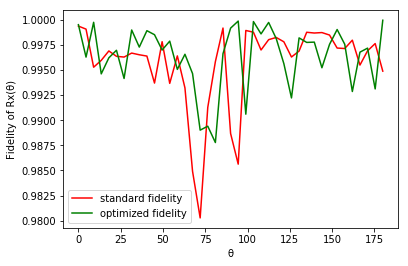

In [277]:
plt.plot(thetas * 180 / np.pi, standard_fidelities, 'r')
plt.plot(thetas * 180 / np.pi, optimized_fidelities, 'g')
plt.xlabel('θ')
plt.ylabel('Fidelity of Rx(θ)')
plt.legend(['standard fidelity', 'optimized fidelity'])

In [29]:
np.mean(standard_fidelities)

0.995683469472822

In [30]:
np.mean(optimized_fidelities)

0.9963825050097577

### plot standard vs. optimized rotation paths

In [43]:
from qiskit.quantum_info.synthesis.one_qubit_decompose import OneQubitEulerDecomposer
from qiskit.quantum_info import Operator
from qiskit.extensions.standard import U3Gate, RXGate

standard_paths = []
optimized_paths = []
for theta in thetas:
    u3 = U3Gate(theta, -np.pi/2, np.pi/2)              # RX(θ) in terms of U3

    decomposer = OneQubitEulerDecomposer(basis='U1X')  # standard way
    standard_circ = decomposer(Operator(u3))
    standard_paths.append(standard_circ)

    decomposer = OneQubitEulerDecomposer(basis='ZXZ')  # optimized way
    optimized_circ = decomposer(Operator(u3))
    optimized_paths.append(optimized_circ)

In [32]:
from qiskit.quantum_info.operators.pauli import pauli_group, Pauli
from qiskit.quantum_info.states import DensityMatrix

paulis = pauli_group(1)
X = paulis[1]
Y = paulis[2]
Z = paulis[3]

ideal_rhos = [DensityMatrix(sv) for sv in ideal_statevectors]
ideal_Xexps = [np.real(np.trace(np.dot(X.to_matrix(), rho.data))) for rho in ideal_rhos]
ideal_Yexps = [np.real(np.trace(np.dot(Y.to_matrix(), rho.data))) for rho in ideal_rhos]
ideal_Zexps = [np.real(np.trace(np.dot(Z.to_matrix(), rho.data))) for rho in ideal_rhos]

std_rhos = [DensityMatrix(sv) for sv in standard_statevectors]
std_Xexps = [np.real(np.trace(np.dot(X.to_matrix(), rho.data))) for rho in std_rhos]
std_Yexps = [np.real(np.trace(np.dot(Y.to_matrix(), rho.data))) for rho in std_rhos]
std_Zexps = [np.real(np.trace(np.dot(Z.to_matrix(), rho.data))) for rho in std_rhos]

opt_rhos = [DensityMatrix(sv) for sv in optimized_statevectors]
opt_Xexps = [np.real(np.trace(np.dot(X.to_matrix(), rho.data))) for rho in opt_rhos]
opt_Yexps = [np.real(np.trace(np.dot(Y.to_matrix(), rho.data))) for rho in opt_rhos]
opt_Zexps = [np.real(np.trace(np.dot(Z.to_matrix(), rho.data))) for rho in opt_rhos]

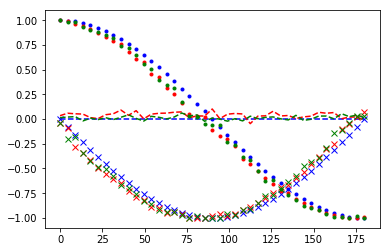

In [33]:
plt.plot(thetas * 180 / np.pi, ideal_Xexps, 'b--')
plt.plot(thetas * 180 / np.pi, ideal_Yexps, 'bx')
plt.plot(thetas * 180 / np.pi, ideal_Zexps, 'b.')

plt.plot(thetas * 180 / np.pi, std_Xexps, 'r--')
plt.plot(thetas * 180 / np.pi, std_Yexps, 'rx')
plt.plot(thetas * 180 / np.pi, std_Zexps, 'r.')

plt.plot(thetas * 180 / np.pi, opt_Xexps, 'g--')
plt.plot(thetas * 180 / np.pi, opt_Yexps, 'gx')
plt.plot(thetas * 180 / np.pi, opt_Zexps, 'g.')

### plot trajectories on Bloch sphere

In [34]:
from qutip import Bloch
import numpy as np
from math import pi
b = Bloch()

/anaconda3/lib/python3.6/subprocess.py:786: ResourceWarning: subprocess 88115 is still running
  ResourceWarning, source=self)
/anaconda3/lib/python3.6/site-packages/qutip/hardware_info.py:44: ResourceWarning: unclosed file <_io.TextIOWrapper name=88 encoding='UTF-8'>
  for l in [l.split(':') for l in os.popen('sysctl hw').readlines()[1:]]:
/anaconda3/lib/python3.6/subprocess.py:786: ResourceWarning: subprocess 88116 is still running
  ResourceWarning, source=self)
/anaconda3/lib/python3.6/site-packages/qutip/hardware_info.py:48: ResourceWarning: unclosed file <_io.TextIOWrapper name=88 encoding='UTF-8'>
  results.update({'cpu_freq': int(float(os.popen('sysctl -n machdep.cpu.brand_string')


In [242]:
b.clear()
b.zlabel = ['$z$', '']
b.point_size = [1, 32, 20, 20]
b.add_points([0,0,0])
b.add_points([std_Xexps, std_Yexps, std_Zexps], meth='l')
b.add_points([opt_Xexps, opt_Yexps, opt_Zexps], meth='l')
#b.add_points([ideal_Xexps, ideal_Yexps, ideal_Zexps], meth='l')

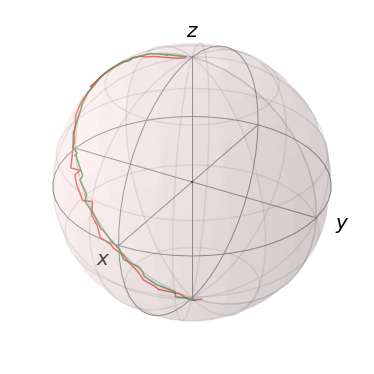

In [243]:
b.show()

### for a sample point, plot gate vs. pulse trajectory of Rx(θ)

In [227]:
sample_point = 15
print('theta: ', 180 * thetas[sample_point] / np.pi)
print(standard_paths[sample_point])
print(optimized_paths[sample_point])

theta:  67.5
        ┌──────────┐┌──────────┐┌────────────┐┌──────────┐┌──────────┐
q_0: |0>┤ U1(pi/2) ├┤ Rx(pi/2) ├┤ U1(4.3197) ├┤ Rx(pi/2) ├┤ U1(pi/2) ├
        └──────────┘└──────────┘└────────────┘└──────────┘└──────────┘
        ┌───────┐┌───────────┐┌───────┐
q_0: |0>┤ Rz(0) ├┤ Rx(3pi/8) ├┤ Rz(0) ├
        └───────┘└───────────┘└───────┘


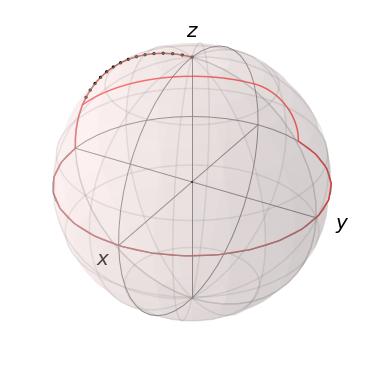

In [230]:
# standard trajectory
b = Bloch()
b.zlabel = ['$z$', '']
b.point_size = [1, 32, 20, 20]
b.point_marker = ['o', 's', '.', '^']
b.add_points([0,0,0])

z1_path = [[0],[0],[0]]

x1_path = [ideal_Xexps[:21],
           ideal_Yexps[:21],
           ideal_Zexps[:21]]

z2_angle = standard_paths[sample_point][2][0].params[0]
z2_path = [list(np.sin(np.linspace(0,z2_angle,20))),
           list(-np.cos(np.linspace(0,z2_angle,20))),
           list(np.zeros(20))]

z2_end_x = z2_path[0][-1]
x2_path = [list(np.full(20, z2_end_x)),
           list(np.sqrt(1-z2_end_x**2)*np.cos(np.linspace(0,np.pi/2,20))),
           list(np.sqrt(1-z2_end_x**2)*np.sin(np.linspace(0,np.pi/2,20)))]

x2_end_x = x2_path[0][-1]
x2_end_y = x2_path[1][-1]
x2_end_z = x2_path[2][-1]

z3_path = [list(np.sqrt(1-x2_end_z**2)*np.cos(np.linspace(np.pi, 3*np.pi/2,20))),
           list(np.sqrt(1-x2_end_z**2)*np.sin(np.linspace(np.pi, 3*np.pi/2,20))),
           list(np.full(20, x2_end_z))]
trajectory = [x1_path[i] + z2_path[i] + x2_path[i] + z3_path[i] for i in (0,1,2)]
b.add_points(trajectory, 'l')

# optimized trajectory
z1_path = [[0],[0],[0]]
x1_path = [ideal_Xexps[:sample_point], ideal_Yexps[:sample_point], ideal_Zexps[:sample_point]]
z2_path = [[0],[0],[0]]
trajectory = [x1_path[i] for i in (0,1,2)]
b.add_points(trajectory, 's')

b.show()